In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
color_pal=sns.color_palette()

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
df.head()

,Product Name,Product Category,Month,Year,Sales,Market Size,Marketing Expense,Month No.
Month-Year,,,,,,,,
2019-01-01,Product J,Cough Suppressant,January,2019,63722,238469,164221,1
2019-02-01,Product J,Cough Suppressant,February,2019,76987,288111,198407,2
2019-03-01,Product J,Cough Suppressant,March,2019,99645,372905,256800,3
2019-04-01,Product J,Cough Suppressant,April,2019,68529,256458,176610,4
2019-05-01,Product J,Cough Suppressant,May,2019,45119,168850,116279,5


In [4]:
sales_j= df.drop(['Product Name','Product Category','Month'],axis=1)

In [5]:
sales_j.head()

,Year,Sales,Market Size,Marketing Expense,Month No.
Month-Year,,,,,
2019-01-01,2019,63722,238469,164221,1
2019-02-01,2019,76987,288111,198407,2
2019-03-01,2019,99645,372905,256800,3
2019-04-01,2019,68529,256458,176610,4
2019-05-01,2019,45119,168850,116279,5


<Axes: title={'center': 'Product J'}, xlabel='Month-Year'>

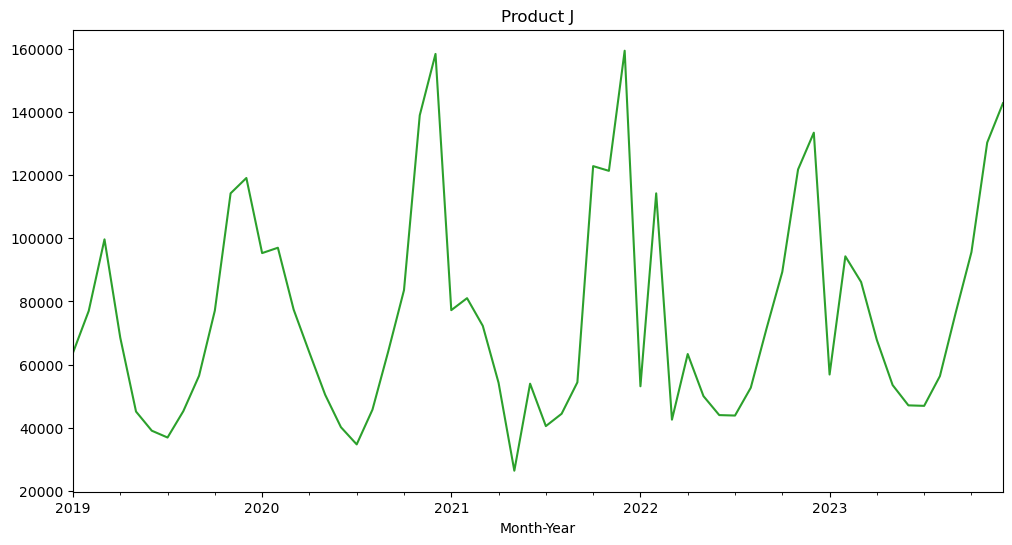

In [6]:
sales_j['Sales'].plot(figsize=(12,6),color=color_pal[2],title='Product J')

<Axes: ylabel='Frequency'>

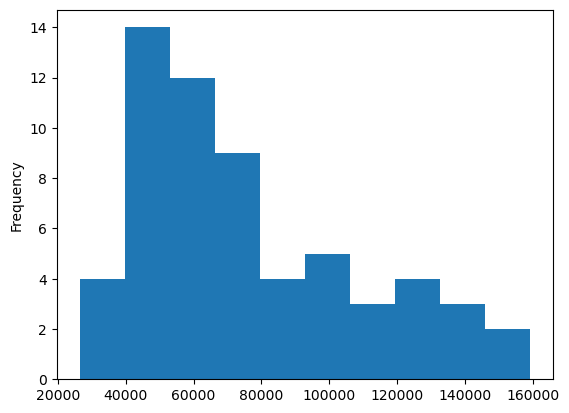

In [7]:
sales_j['Sales'].plot(kind='hist')

# Visualization

In [8]:
sales_j.head()

,Year,Sales,Market Size,Marketing Expense,Month No.
Month-Year,,,,,
2019-01-01,2019,63722,238469,164221,1
2019-02-01,2019,76987,288111,198407,2
2019-03-01,2019,99645,372905,256800,3
2019-04-01,2019,68529,256458,176610,4
2019-05-01,2019,45119,168850,116279,5


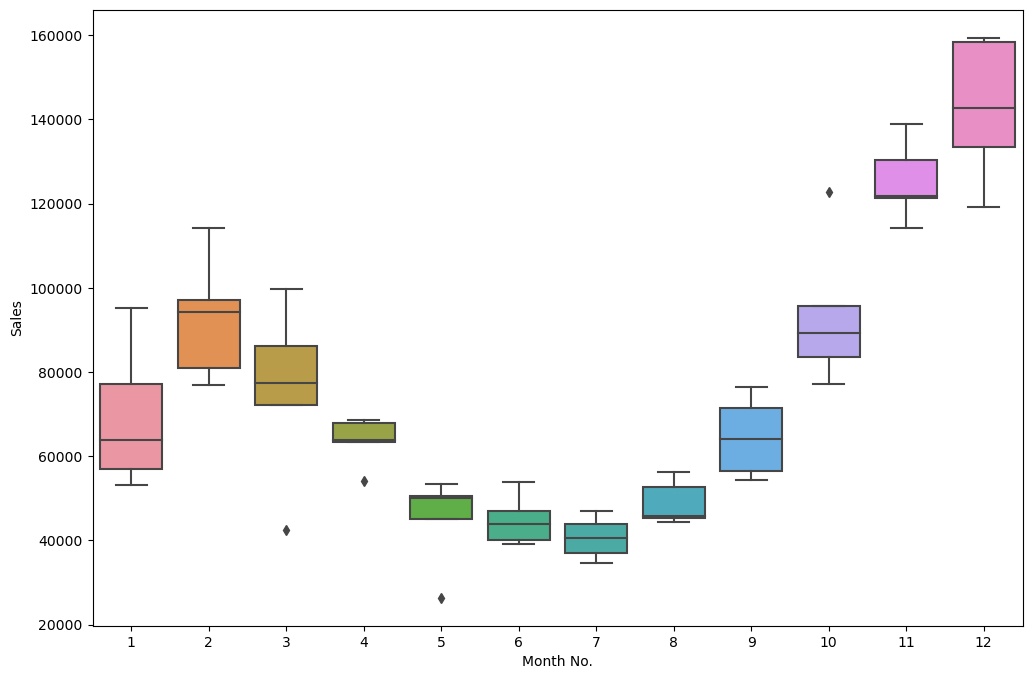

In [9]:
plt.figure(figsize=(12,8))
sns.boxplot(data=sales_j, x='Month No.',y='Sales')
plt.show()

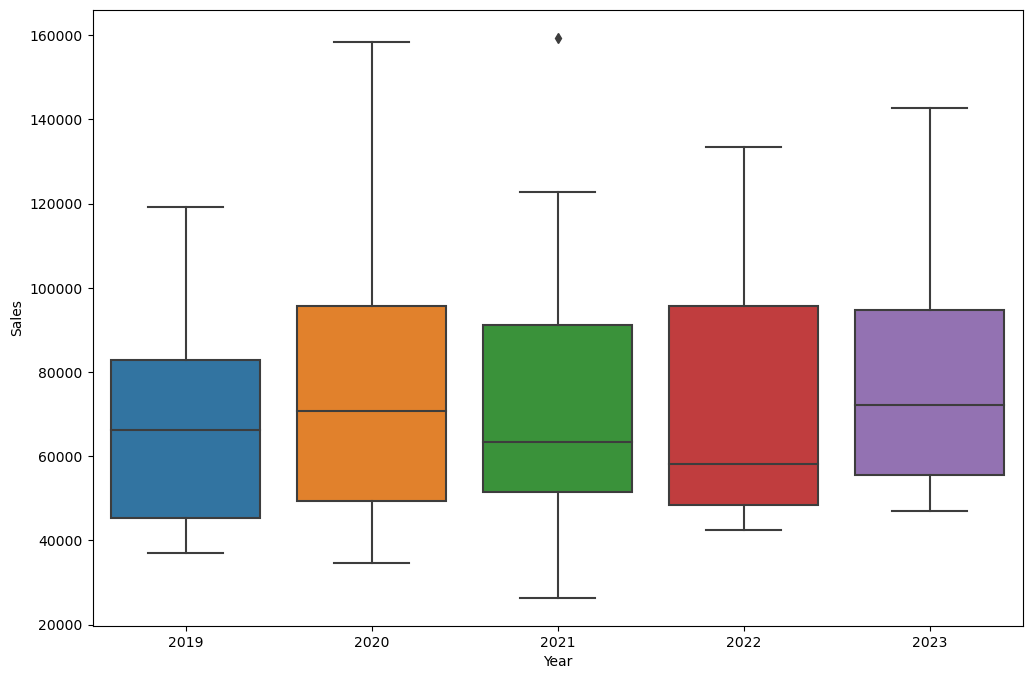

In [10]:
plt.figure(figsize=(12,8))
sns.boxplot(data=sales_j, x='Year',y='Sales')
plt.show()

# Feature Engineering

In [11]:
sales_j= df.drop(['Product Name','Product Category','Month','Month No.','Year'],axis=1)

In [12]:
sales_j['quarter'] = sales_j.index.quarter
sales_j['month'] = sales_j.index.month
sales_j['year'] = sales_j.index.year

In [13]:
# Create lagged values
lagged_intervals = [6, 7, 8]  # Lagged intervals in months
for lag in lagged_intervals:
    sales_j[f'sales_lag_{lag}'] = sales_j['Sales'].shift(lag)

In [14]:
print(sales_j)

             Sales  Market Size  Marketing Expense  quarter  month  year  \
Month-Year                                                                 
2019-01-01   63722       238469             164221        1      1  2019   
2019-02-01   76987       288111             198407        1      2  2019   
2019-03-01   99645       372905             256800        1      3  2019   
2019-04-01   68529       256458             176610        2      4  2019   
2019-05-01   45119       168850             116279        2      5  2019   
2019-06-01   39059       146172             100661        2      6  2019   
2019-07-01   36898       138085              95092        3      7  2019   
2019-08-01   45234       169281             116575        3      8  2019   
2019-09-01   56459       211288             145504        3      9  2019   
2019-10-01   77083       427430             294350        4     10  2019   
2019-11-01  114215       445603             306864        4     11  2019   
2019-12-01  

# Train/Test Split

In [15]:
train= sales_j[:54]
test=sales_j[54:]

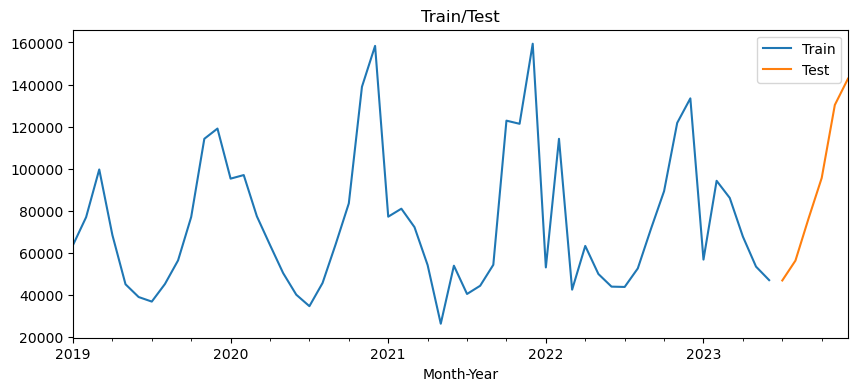

In [16]:
fig,ax=plt.subplots(figsize=(10,4))
train['Sales'].plot(ax=ax,label='Train set',title='Train/Test')
test['Sales'].plot(ax=ax,label='Test set')
plt.legend(['Train','Test'])
plt.show()

In [17]:
len(train)

54

In [18]:
x_train = train.drop(columns=['Sales'])
y_train=train['Sales']
x_test=test.drop(columns=['Sales'])
y_test=test['Sales']

In [19]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000, 2000],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# Instantiate the XGBoost regressor
regressor = xgb.XGBRegressor(objective='reg:squarederror')

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Access the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters:", best_params)
print("Best estimator:", best_estimator)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Best estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [20]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       colsample_bytree=0.8,
                       subsample= 0.8,
                       early_stopping_rounds=50,
                       learning_rate=0.1)

reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:73624.97353	validation_1-rmse:90297.86573
[100]	validation_0-rmse:1095.65376	validation_1-rmse:6629.02397
[130]	validation_0-rmse:623.64619	validation_1-rmse:6630.20948


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
reg.best_iteration

81

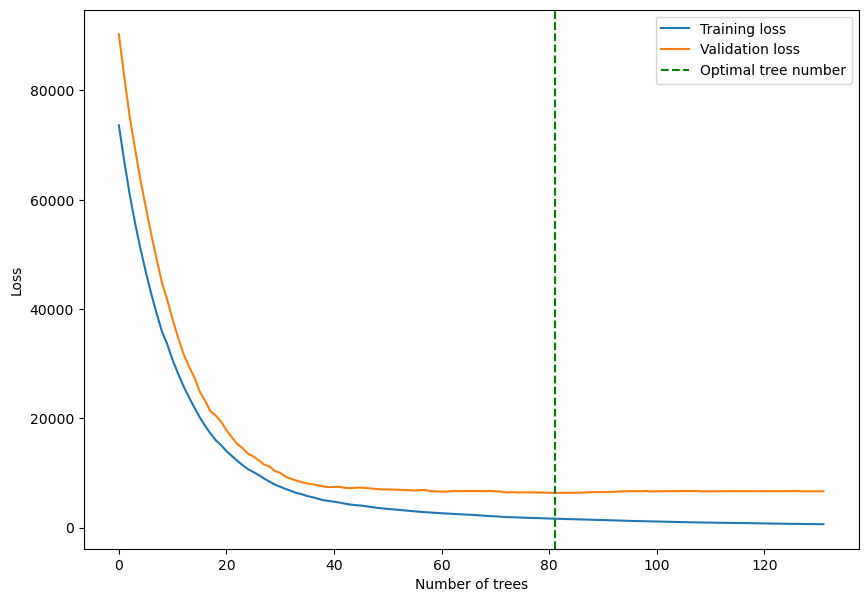

In [22]:
results = reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(81,color='green',ls='--', label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

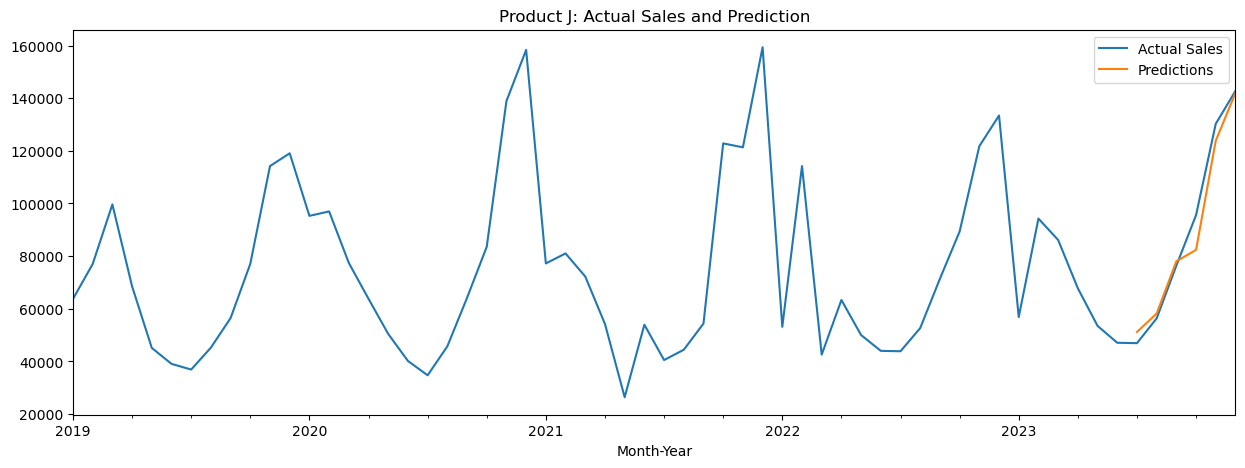

In [23]:
pred=reg.predict(x_test)
sales_j['prediction']=[None]*len(train) + list(pred)

ax = sales_j['Sales'].plot(figsize=(15, 5))
sales_j['prediction'].plot()
plt.legend(['Actual Sales', 'Predictions'])
ax.set_title('Product J: Actual Sales and Prediction')
plt.show()

In [24]:
mae_xgb= mean_absolute_error(test['Sales'],pred)
mse_xgb=mean_squared_error(test['Sales'], pred)
mape_xgb= mean_absolute_percentage_error(test['Sales'],pred)
rmse_xgb= np.sqrt(mean_squared_error(test['Sales'],pred))

print(f'MAE - XGBoost: {mae_xgb:0.3f}')
print(f'MAPE - XGBoost: {mape_xgb:0.3f}')
print(f'MSE - XGBoost: {mse_xgb:0.3f}')
print(f'RMSE - XGBoost: {rmse_xgb:0.3f}')

MAE - XGBoost: 4688.855
MAPE - XGBoost: 0.056
MSE - XGBoost: 40189742.946
RMSE - XGBoost: 6339.538


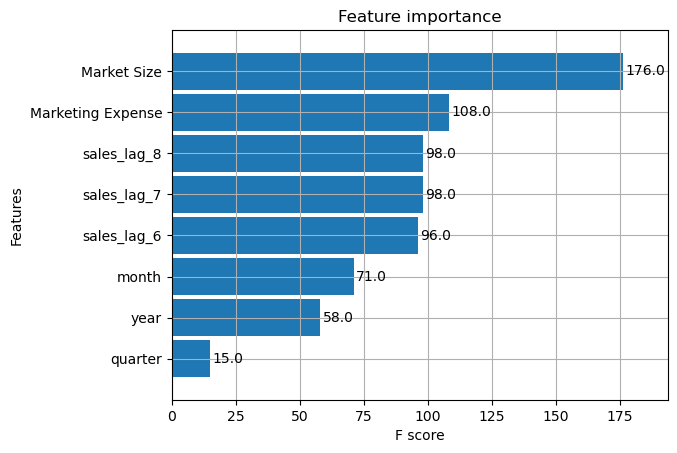

In [25]:
from xgboost import plot_importance

_ = plot_importance(reg, height=0.9)